## Setup

In [1]:
from imports import *
from constants import *
from functions import *
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.feature_extraction import text
import warnings
import re

In [2]:
warnings.filterwarnings("ignore")

### Feature Extraction - Count Vectorizer

In [3]:
my_df = readCSV(CLEAN_DATASET)

In [4]:
x = my_df.text
y = my_df.target
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x,y,test_size=.02,random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

def showSets(name, x, y):
    print("{0} set has a total {1} entries with {2:.2f}% negative, {3:.2f}% positive".format(name,len(x), (len(x[y == 0]) / (len(x)*1.))*100, (len(x[y == 1]) / (len(x)*1.))*100))

showSets("Training", x_train, y_train)
showSets("Validation", x_validation, y_validation)
showSets("Testing", x_test, y_test)
print(len(x_test))
print(len(y_test))

Training set has a total 1564120 entries with 50.02% negative, 49.98% positive
Validation set has a total 15960 entries with 49.45% negative, 50.55% positive
Testing set has a total 15961 entries with 49.68% negative, 50.32% positive
15961
15961


In [5]:
train_split_df = pd.DataFrame()
train_split_df["x_train"] = x_train
train_split_df["y_train"] = y_train
train_split_df.to_csv("data/train_split.csv")
validation_df = pd.DataFrame()
validation_df["x_validation"] = x_validation
validation_df["y_validation"] = y_validation
validation_df.to_csv("data/validation_split.csv")
test_df = pd.DataFrame()
test_df["x_test"] = x_test
test_df["y_test"] = y_test
test_df.to_csv("data/test_split.csv")

#### Baseline

In [6]:
tbresult = [TextBlob(i).sentiment.polarity for i in x_validation]
tbpred = [0 if n < 0 else 1 for n in tbresult]

conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0], normalize = 'true'))
confusion = pd.DataFrame(conmat, index=['positive','negative'], columns=['predicted_positive', 'predicted_negative'])

print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation,tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)
print("-"*80)
print("Clasification Report\n")
print(classification_report(y_validation, tbpred))

Accuracy Score: 61.84%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive            0.902690            0.097310
negative            0.672241            0.327759
--------------------------------------------------------------------------------
Clasification Report

              precision    recall  f1-score   support

           0       0.77      0.33      0.46      7893
           1       0.58      0.90      0.71      8067

    accuracy                           0.62     15960
   macro avg       0.67      0.62      0.58     15960
weighted avg       0.67      0.62      0.58     15960



TextBlob provide us almost 62% of accuracy. This is higher than the null accuracy 

In [7]:
train_df = readCSV("train_split.csv")
x_train = train_df["x_train"]
y_train = train_df["y_train"]
test_df = readCSV("test_split.csv")
x_test = test_df["x_test"]
y_test = test_df["y_test"]
validation_df = readCSV("validation_split.csv")
x_validation = validation_df["x_validation"]
y_validation = validation_df["y_validation"]

In [8]:
def getName(obj):
    txt = str(type(obj))
    match = re.search(r"'([^']*)'", txt)  # Match single-quoted string
    return str.lower(match.group(1).split(".")[-1])  # Extract the matched text

def predict(pipeline, x_train, y_train, x_test, prefix, features):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    tpred = time() - t0
    name = "results/" + prefix + "-" + "-".join(list(map(getName,pipeline.named_steps.values()))) + "-" + str(features) + ".csv"
    pred_df = pd.DataFrame()
    pred_df['y_pred'] = y_pred
    saveDF(pred_df,name)
    return y_pred, tpred

cvec = CountVectorizer()
lr = LogisticRegression()

checker_pipeline = Pipeline([
            ('vectorizer', cvec),
            ('classifier', lr)
])

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test, prefix, features):
    auxAcc = len(x_test[y_test == 0]) / (len(x_test)*1.) 
    null_accuracy = max(1-auxAcc, auxAcc)
    y_pred, train_test_time = predict(pipeline, x_train, y_train, x_test,prefix,features)
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr, prefix=""):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation, prefix, n)
        result.append((n,nfeature_accuracy,tt_time))
    return result

We check that out top 10 words are a subset of the english stop words

In [10]:
term_freq_df = readCSV(TF_DATASET)
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total',ascending=False).iloc[:10].index))
set(my_stop_words).issubset(set(text.ENGLISH_STOP_WORDS))

True

We run the algorithm to obtain the results

In [11]:
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english', prefix="wows")

RESULT FOR UNIGRAM WITHOUT STOP WORDS
LogisticRegression()


Validation result for 10000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 77.27%
model is 26.73% more accurate than null accuracy
train and test time: 29.35s
--------------------------------------------------------------------------------
Validation result for 20000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 77.63%
model is 27.08% more accurate than null accuracy
train and test time: 30.14s
--------------------------------------------------------------------------------
Validation result for 30000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 77.63%
model is 27.09% more accurate than null accuracy
train and test time: 29.27s
--------------------------------------------------------------------------------
Validation result for 40000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 77.61%
model is 27.07% more accurate than null accuracy
train and test t

In [12]:
print("RESULT FOR UNIGRAM WITH STOP WORDS")
feature_result_ug = nfeature_accuracy_checker(prefix="ug")

RESULT FOR UNIGRAM WITH STOP WORDS
LogisticRegression()


Validation result for 10000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 79.63%
model is 29.09% more accurate than null accuracy
train and test time: 30.26s
--------------------------------------------------------------------------------
Validation result for 20000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 79.94%
model is 29.39% more accurate than null accuracy
train and test time: 30.46s
--------------------------------------------------------------------------------
Validation result for 30000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 79.89%
model is 29.34% more accurate than null accuracy
train and test time: 30.90s
--------------------------------------------------------------------------------
Validation result for 40000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 79.81%
model is 29.26% more accurate than null accuracy
train and test time

In [13]:
my_stop_words = (list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words, prefix="wocsw")

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)
LogisticRegression()


Validation result for 10000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 78.83%
model is 28.29% more accurate than null accuracy
train and test time: 29.49s
--------------------------------------------------------------------------------
Validation result for 20000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 79.10%
model is 28.56% more accurate than null accuracy
train and test time: 32.18s
--------------------------------------------------------------------------------
Validation result for 30000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 78.98%
model is 28.44% more accurate than null accuracy
train and test time: 32.90s
--------------------------------------------------------------------------------
Validation result for 40000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 79.08%
model is 28.53% more accurate than

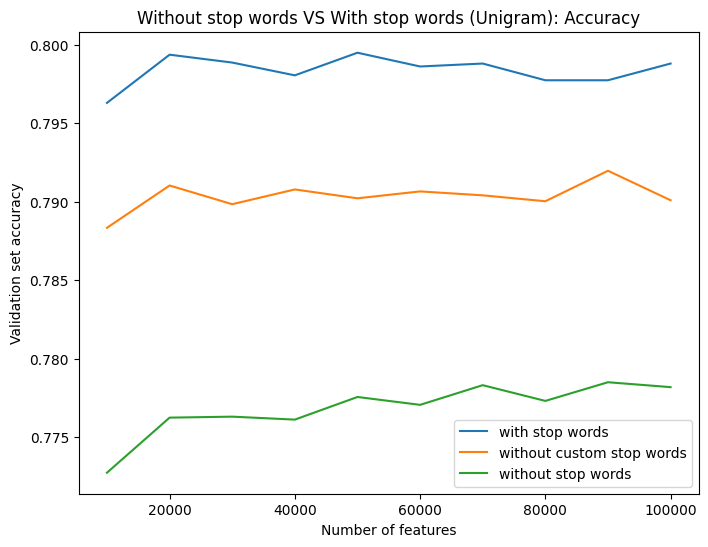

In [14]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

Also experiment with ngrams

In [15]:
print("RESULT FOR BIGRAM WITH STOP WORDS")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2), prefix="bg")

RESULT FOR BIGRAM WITH STOP WORDS
LogisticRegression()


Validation result for 10000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 80.75%
model is 30.20% more accurate than null accuracy
train and test time: 59.88s
--------------------------------------------------------------------------------
Validation result for 20000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 81.33%
model is 30.78% more accurate than null accuracy
train and test time: 64.05s
--------------------------------------------------------------------------------
Validation result for 30000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 81.74%
model is 31.19% more accurate than null accuracy
train and test time: 64.40s
--------------------------------------------------------------------------------
Validation result for 40000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 82.07%
model is 31.53% more accurate than null accuracy
train and test time:

In [16]:
print("RESULT FOR TRIGRAM WITH STOP WORDS")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3), prefix="tg")

RESULT FOR TRIGRAM WITH STOP WORDS
LogisticRegression()


Validation result for 10000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 80.86%
model is 30.31% more accurate than null accuracy
train and test time: 158.19s
--------------------------------------------------------------------------------
Validation result for 20000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 81.30%
model is 30.76% more accurate than null accuracy
train and test time: 172.48s
--------------------------------------------------------------------------------
Validation result for 30000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 81.75%
model is 31.20% more accurate than null accuracy
train and test time: 130.56s
--------------------------------------------------------------------------------
Validation result for 40000 features
15960
15960
15961
null accuracy: 50.55%
accuracy score: 81.95%
model is 31.41% more accurate than null accuracy
train and test t

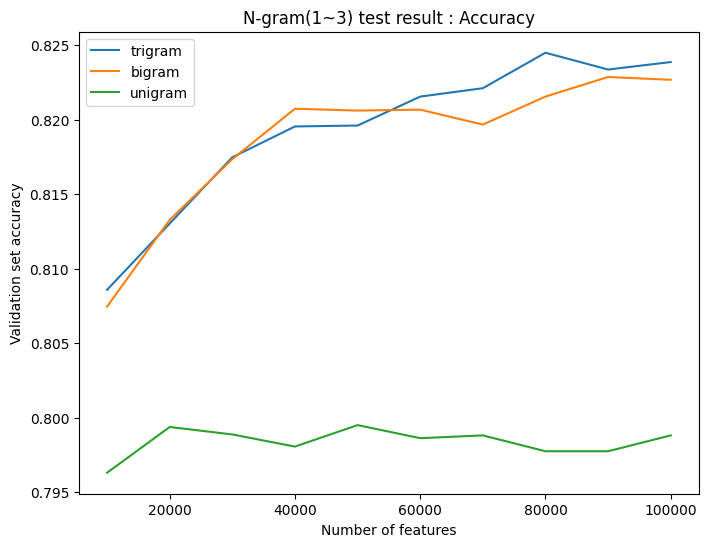

In [17]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
saveDF(nfeatures_plot_tg,"nfeatures_plot_tg.csv")
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
saveDF(nfeatures_plot_bg,"nfeatures_plot_bg.csv")
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

We can see that the best performance is obtained with the trigram with stopwords

And explore the confusion matrixes

In [18]:
def evaluate(predFileRoute, y_test):
    df =  pd.read_csv("data/results/" + predFileRoute, index_col=0)
    df.columns = ["predictions"]
    y_pred = df["predictions"]
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("-"*80)
    print("Confusion Matrix")
    print(confusion)
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['negative','positive']))

In [19]:
evaluate("ug-countvectorizer-logisticregression-90000.csv", y_validation)

accuracy score: 79.77%
--------------------------------------------------------------------------------
Confusion Matrix
          predicted_negative  predicted_positive
negative                6096                1797
positive                1431                6636
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.77      0.79      7893
    positive       0.79      0.82      0.80      8067

    accuracy                           0.80     15960
   macro avg       0.80      0.80      0.80     15960
weighted avg       0.80      0.80      0.80     15960

